In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from scipy.io.matlab import loadmat
import string

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
def load_idx3_ubyte(file_path='data/t10k-images.idx3-ubyte'):

    with open(file_path, 'rb') as f:
        
        magic_number = int.from_bytes(f.read(4), 'big')
        num_items = int.from_bytes(f.read(4), 'big')

        if magic_number == 2051:  # Fichier d'images
            num_rows = int.from_bytes(f.read(4), 'big')
            num_cols = int.from_bytes(f.read(4), 'big')
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_items, num_rows, num_cols)
            
        elif magic_number == 2049:  # Fichier d'étiquettes
            data = np.frombuffer(f.read(), dtype=np.uint8)
            
        else:
            raise ValueError("Format de fichier .idx3-ubyte non reconnu")
            
    return data


def lire_alpha_digit(file_path='data/binaryalphadigs.mat',caractere=['0']):
    
    assert caractere, "List not empty"

    elements = [str(i) for i in range(10)] + list(string.ascii_uppercase)
    
    index_caractere_list = [elements.index(c) for c in caractere if c in elements]
    if not index_caractere_list:
        raise ValueError("One or many caracters are not recognized.")

    data = loadmat(file_path)
    
    size_img = data['dat'][0][0].shape
    nb_pixel = size_img[0]*size_img[1]
    

    X = data['dat'][np.array(index_caractere_list)]
    X = np.concatenate(X)
    X = np.concatenate(X).reshape((X.shape[0],nb_pixel))

    return X, size_img

In [3]:
def plot_images(X, size_img):
    num_images = len(X)
    
    # Calculate the number of rows and columns for the subplots
    cols = np.ceil(np.sqrt(num_images)) 
    rows = np.ceil(num_images / cols)     
    
    fig, axes = plt.subplots(int(rows), int(cols), figsize=(cols * 2, rows * 2))
    axes = axes.flatten() 
    
    for i, image in enumerate(X):
        image = image.reshape(size_img)
        axes[i].imshow(image, cmap='gray')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout() 
    plt.show()

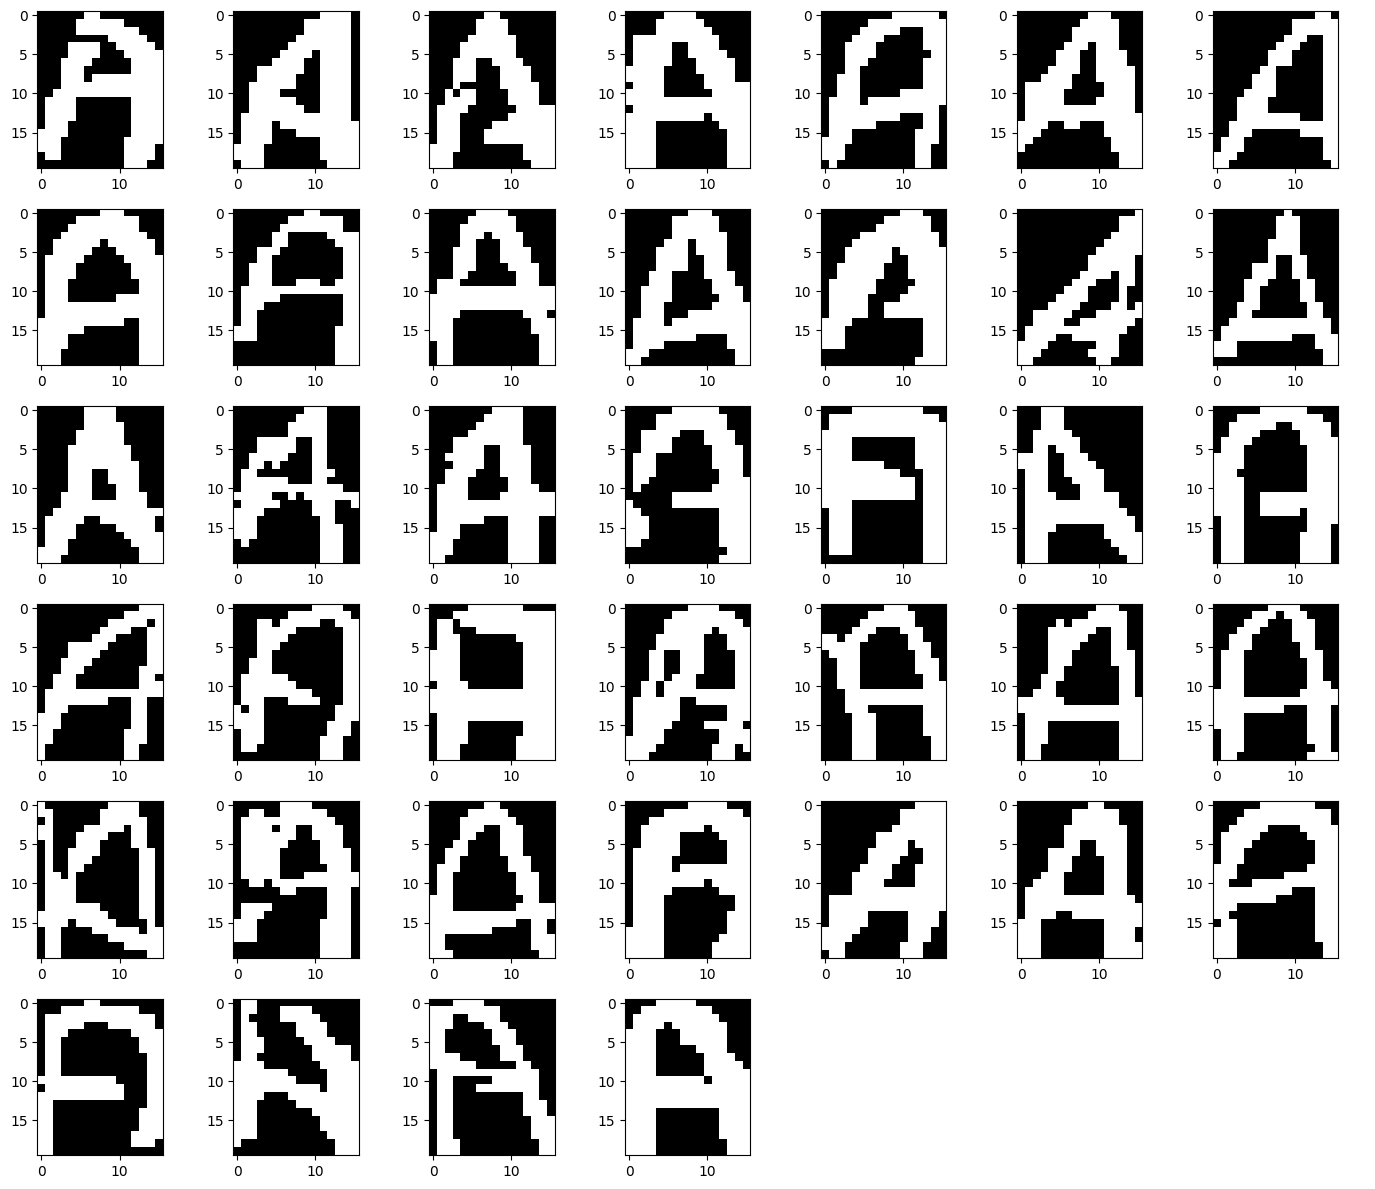

In [4]:
X, size_img = lire_alpha_digit('data/binaryalphadigs.mat',caractere=['A'])
plot_images(X, size_img)

# RBM Construction and test on Binary Alpha digits

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [87]:
class RBM:
    def __init__(self, p, q):
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.W = np.random.normal(size=(p, q)) * np.sqrt(0.01)

    def entree_sortie_RBM(self, V):
        return sigmoid(V @ self.W + self.b) 

    def sortie_entree_RBM(self, H):
        return sigmoid(H @ self.W.T + self.a)

    def train_RBM(self, X, learning_rate, len_batch, n_epochs,verbose=1):
        p, q = self.W.shape

        n_samples = X.shape[0]
    
        for epoch in range(n_epochs):
            
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            
            for ith_batch in range(0, n_samples, len_batch):
                
                X_batch = X_shuffled[ith_batch:ith_batch + len_batch]
                t_batch_i = X_batch.shape[0]

                #Contrastive-Divergence-1 algorithm to estimate the gradient
                V0 = copy.deepcopy(X_batch)
                
                pH_V0 = self.entree_sortie_RBM(V0)
                # draw from pH_V0
                H0 = (np.random.rand(t_batch_i, q) < pH_V0) * 1
                
                pV_H0 = self.sortie_entree_RBM(H0)
                # draw from pV_H0
                V1 = (np.random.rand(t_batch_i, p) < pV_H0) * 1
                
                pH_V1 = self.entree_sortie_RBM(V1)

                grad_a = np.sum(V0 - V1, axis=0)
                grad_b = np.sum(pH_V0 - pH_V1, axis=0)
                grad_W = V0.T @ pH_V0 - V1.T @ pH_V1

                self.a += learning_rate * grad_a
                self.b += learning_rate * grad_b
                self.W += learning_rate * grad_W

            # Reconstruction's loss
            H = self.entree_sortie_RBM(X_shuffled)
            X_rec = self.sortie_entree_RBM(H)
            loss = np.mean((X_shuffled - X_rec) ** 2) #quadratic norm

            if epoch % 10 == 0 and verbose: # verbose for progression bar
                print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss:.4f}")
    
    def generer_image_RBM(self, nb_images, nb_iter):
        p, q = self.W.shape
        images = []
        
        for i in range(nb_images):  # Gibbs
            v = (np.random.rand(p) < 0.5) * 1
            for j in range(nb_iter):
                h = (np.random.rand(q) < self.entree_sortie_RBM(v)) * 1
                v = (np.random.rand(p) < self.sortie_entree_RBM(h)) * 1
            images.append(v)
            
        return images

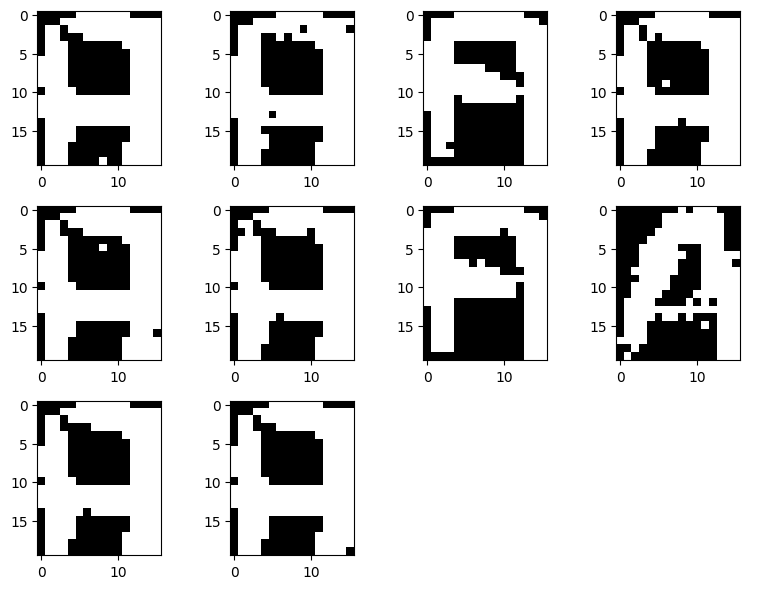

In [80]:
X, size_img = lire_alpha_digit('data/binaryalphadigs.mat', caractere=['A'])

nb_features = size_img[0] * size_img[1]
p, q = nb_features, 100
rbm = RBM(p, q)  # Instance of RBM

rbm.train_RBM(X, learning_rate=10 ** (-2), len_batch=10, n_epochs=1000, verbose=0)

generated_images = rbm.generer_image_RBM(nb_images=10, nb_iter=200)
plot_images(generated_images, size_img)

# DBN Construction and test on Binary Alpha digits

In [81]:
class DBN:
    def __init__(self, dbn_size):
        """
        :param dbn_size: List [] of numbers of neurons per layer.
        """
        self.dbn_size = dbn_size
        self.rbms = []  # List to store RBMs

        # Initialize RBMs for each pair of consecutive layers
        for l in range(len(dbn_size) - 1):
            p = dbn_size[l]
            q = dbn_size[l + 1]
            rbm = RBM(p, q)
            self.rbms.append(rbm)

    def train_DBN(self, X, learning_rate, len_batch, n_epochs, verbose=1):
        
        tmp = copy.deepcopy(X)
        
        #Greedy layer wise procedure
        for l in range(len(self.dbn_size) - 1):
            if verbose:
                print(f"Train RBM {l+1}/{len(self.dbn_size)-1}\t") 
            self.rbms[l].train_RBM(tmp, learning_rate, len_batch, n_epochs,verbose)
            tmp = self.rbms[l].entree_sortie_RBM(tmp)


    def generer_image_DBN(self, nb_images, nb_iter):
        
        p = self.dbn_size[0]  # Size of the visible layer of the first RBM
        images = []
    
        for i in range(nb_images):
            # Random initialization of the visible layer
            v = (np.random.rand(p) < 0.5) * 1
    
            # Gibbs sampling across all layers
            for _ in range(nb_iter):
                # Forward propagation (visible -> hidden)
                h = v
                for rbm in self.rbms:
                    p_rbm, q_rbm = rbm.W.shape
                    h = (np.random.rand(q_rbm) < rbm.entree_sortie_RBM(h)) * 1
    
                # Backward propagation (hidden -> visible)
                v = h
                for rbm in reversed(self.rbms):
                    p_rbm, q_rbm = rbm.W.shape
                    v = (np.random.rand(p_rbm) < rbm.sortie_entree_RBM(v)) * 1
                    
            images.append(v)

        return images

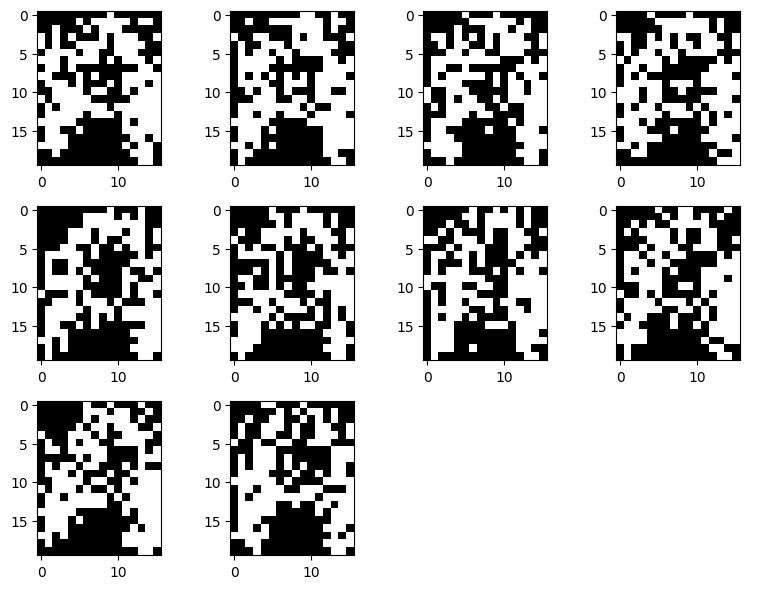

In [82]:
X, size_img = lire_alpha_digit('data/binaryalphadigs.mat',caractere=['A'])

dbn_size = [320, 200, 100]
dbn = DBN(dbn_size) #Instance of DBN
dbn.train_DBN(X, learning_rate=1e-1, len_batch=128, n_epochs=100, verbose=0)

generated_images = dbn.generer_image_DBN(nb_images=10, nb_iter=200)
plot_images(generated_images, size_img)

# DNN and Test on MNIST

In [83]:
def process_images_MNIST(file_path='data/train-images-idx3-ubyte'):
    images = load_idx3_ubyte(file_path)
    
    size_img = images[0].shape
    images = images.reshape((images.shape[0],size_img[0]*size_img[1]))
    
    images = np.round(images/255) # binary MNIST
    
    return images, size_img

def one_hot_encoding(labels, nb_classes):
    """
    Converts a label vector into a one-hot encoded matrix.
    """
    one_hot = np.zeros((len(labels), nb_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

def calcul_softmax(X):
    """
    Args:
        X (np.ndarray)
    """
    assert isinstance(X, np.ndarray), "Please use array."
    
    if X.ndim == 1:
        return np.exp(X)/np.sum(np.exp(X))
    elif X.ndim == 2:
        return np.exp(X)/np.sum(np.exp(X), axis=1, keepdims=True)
    else:    
        raise ValueError("1 or 2 dimensional array.")

In [84]:
class DNN:
    def __init__(self, network_size):
        """
        Args:
            network_size: size of the network including the layer for classification
        """
        self.dbn = DBN(network_size[:-1])
        nb_classes = network_size[-1]
        self.W_l = np.random.randn(network_size[-2], nb_classes) * np.sqrt(0.01)  # Weights for classification layer
        self.b_l = np.zeros(nb_classes)  # Bias for classification layer


    def pretrain_DNN(self, X, learning_rate, len_batch, n_epochs, verbose=1):
        self.dbn.train_DBN(X, learning_rate, len_batch, n_epochs, verbose)

    def entree_sortie_reseau(self, X):
        """
        Store and return inputs + the outputs of each layer.
        """
        
        outputs = [X]
        
        h = copy.deepcopy(X)
        for rbm in self.dbn.rbms:
            h = rbm.entree_sortie_RBM(h)
            outputs.append(h)

        y_hat = calcul_softmax(h @ self.W_l + self.b_l)
        outputs.append(y_hat)
    
        return outputs

    def retropropagation(self, X, labels, learning_rate, len_batch, n_epochs, verbose=1):
        """
        Perform backpropagation to fine-tune the DBN using labels.
        Args:
            labels (np.ndarray): one-hot encoded labels.
        """
        
        n_samples = X.shape[0]
    
        for epoch in range(n_epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = labels[indices]
    
            for ith_batch in range(0, n_samples, len_batch):

                X_batch = X_shuffled[ith_batch:ith_batch + len_batch]
                y_batch = y_shuffled[ith_batch:ith_batch + len_batch]

                m = X_batch.shape[0]
    
                # Forward pass
                outputs = self.entree_sortie_reseau(X_batch)
                y_hat = outputs[-1]
                
                c = y_hat - y_batch  
    
                # Backward pass
                grad_w = outputs[-2].T @ c / m 
                grad_b = np.mean(c, axis=0) 
    
                weight = copy.deepcopy(self.W_l)
                
                self.W_l -= learning_rate * grad_w
                self.b_l -= learning_rate * grad_b
    
                for l in range(len(outputs)-2, 0, -1):
                    x = outputs[l]
                    c = (c @ weight.T) * (x * (1 - x))

                    x_prev = outputs[l-1]
                    grad_w = x_prev.T @ c / m
                    grad_b = np.mean(c, axis=0)

                    rbm = self.dbn.rbms[l-1]
                    weight = copy.deepcopy(rbm.W)
    
                    # Update RBM weights and biases
                    rbm.W -= learning_rate * grad_w
                    rbm.b -= learning_rate * grad_b

            # Reconstruction of the Cross-entropy loss
            outputs = self.entree_sortie_reseau(X_shuffled)
            y_hat = outputs[-1]

            # Cross-entropy loss
            loss = -np.sum(y_shuffled * np.log(y_hat)) / n_samples
            
            if epoch % 10 == 0 and verbose:             
                print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss:.4f}")
                
    def test_DNN(self, X, labels):
        """
        Compute the error rate.
        
        Args:
            labels (np.ndarray).
        """
        
        # Retrieve estimated label
        outputs = self.entree_sortie_reseau(X)
        y_hat = outputs[-1]
        label_estimated = np.argmax(y_hat, axis=1)

        errors = [0 if x==y else 1 for (x,y) in zip(labels, label_estimated)]
    
        return sum(errors)/len(errors)

In [85]:
nb_classes = 10

train_images, train_size_img = process_images_MNIST('data/train-images-idx3-ubyte')
train_labels = load_idx3_ubyte('data/train-labels-idx1-ubyte')
encoded_train_labels = one_hot_encoding(train_labels, nb_classes)

test_images, test_size_img = process_images_MNIST('data/t10k-images-idx3-ubyte')
test_labels = load_idx3_ubyte('data/t10k-labels-idx1-ubyte')

nb_features = train_size_img[0]*train_size_img[1]

In [86]:
dnn_pretrained = DNN(network_size=[nb_features, 200, 200, nb_classes])

print("----------------------------------------------------- Pre-training -----------------------------------------------------")
dnn_pretrained.pretrain_DNN(train_images,learning_rate=1e-1, len_batch=128, n_epochs=10)
print("----------------------------------------------------- Back-Propragation -----------------------------------------------------")
dnn_pretrained.retropropagation(train_images, encoded_train_labels, learning_rate=1e-1, len_batch=128, n_epochs=20)
print("----------------------------------------------------- Error Rate -----------------------------------------------------")
error_rate = dnn_pretrained.test_DNN(test_images, test_labels)
print(f"Error rate: {error_rate*100}%")

----------------------------------------------------- Pre-training -----------------------------------------------------
Train RBM 1/2	
Epoch 1/10, Loss: 0.0950
Train RBM 2/2	
Epoch 1/10, Loss: 0.0012
----------------------------------------------------- Back-Propragation -----------------------------------------------------
Epoch 1/20, Loss: 1.8200
Epoch 11/20, Loss: 1.3149
----------------------------------------------------- Error Rate -----------------------------------------------------
Error rate: 46.89%


In [56]:
dnn = DNN(network_size=[nb_features, 200, 200, nb_classes])

print("----------------------------------------------------- Back-Propragation -----------------------------------------------------")
dnn.retropropagation(train_images, encoded_train_labels, learning_rate=1e-1, len_batch=128, n_epochs=20)

print("----------------------------------------------------- Error Rate -----------------------------------------------------")
error_rate = dnn.test_DNN(test_images, test_labels)
print(f"Error rate: {error_rate*100}%")

----------------------------------------------------- Back-Propragation -----------------------------------------------------
Epoch 1/20, Loss: 0.7149
Epoch 11/20, Loss: 0.2498
----------------------------------------------------- Error Rate -----------------------------------------------------
Error rate: 5.7299999999999995%


# Analysis

In [ ]:
nb_classes = 10

train_images, train_size_img = process_images_MNIST('data/train-images-idx3-ubyte')
train_labels = load_idx3_ubyte('data/train-labels-idx1-ubyte')
encoded_train_labels = one_hot_encoding(train_labels, nb_classes)

test_images, test_size_img = process_images_MNIST('data/t10k-images-idx3-ubyte')
test_labels = load_idx3_ubyte('data/t10k-labels-idx1-ubyte')

nb_features = train_size_img[0]*train_size_img[1]

In [ ]:
def train_and_test_dnn(network_size, train_images, encoded_train_labels, test_images, test_labels, pretrain=True):
    dnn = DNN(network_size=network_size)
    if pretrain:
        dnn.pretrain_DNN(train_images, learning_rate=1e-2, len_batch=128, n_epochs=100, verbose=0)
    dnn.retropropagation(train_images, encoded_train_labels, learning_rate=1e-2, len_batch=128, n_epochs=200, verbose=0)
    return dnn.test_DNN(test_images, test_labels)

In [ ]:
nb_layers_dbn = np.arange(1,6)

networks_size = [[nb_features] + [200]*i + [nb_classes] for i in nb_layers_dbn]

e_pretrained_dnn = []
e_dnn = []

for s in networks_size:
    error_rate = train_and_test_dnn(s, train_images, encoded_train_labels, test_images, test_labels)
    e_pretrained_dnn.append(error_rate)

    error_rate = train_and_test_dnn(s, train_images, encoded_train_labels, test_images, test_labels, pretrain=False)
    e_dnn.append(error_rate)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(nb_layers_dbn, e_pretrained_dnn, label='Pre-trained DNN', marker='o')
axs[0].set_title('Pre-trained DNN')
axs[0].set_xlabel('Number of Hidden layers in DBN')
axs[0].set_ylabel('Error Rate')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(nb_layers_dbn, e_dnn, label='Standard DNN', marker='o', color='orange')
axs[1].set_title('Standard DNN')
axs[1].set_xlabel('Number of Hidden layers in DBN')
axs[1].set_ylabel('Error Rate')
axs[1].grid(True)
axs[1].legend()

fig.suptitle('Error Rate vs. Number of Layers in DBN', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

In [ ]:
nb_neurons_dbn = np.arange(1,8)*100

networks_size = [[nb_features] + [n,n] + [nb_classes] for n in nb_neurons_dbn]

e_pretrained_dnn = []
e_dnn = []

for s in networks_size:
    error_rate = train_and_test_dnn(s, train_images, encoded_train_labels, test_images, test_labels)
    e_pretrained_dnn.append(error_rate)

    error_rate = train_and_test_dnn(s, train_images, encoded_train_labels, test_images, test_labels, pretrain=False)
    e_dnn.append(error_rate)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(nb_neurons_dbn, e_pretrained_dnn, label='Pre-trained DNN', marker='o')
axs[0].set_title('Pre-trained DNN')
axs[0].set_xlabel('Number of Neurons')
axs[0].set_ylabel('Error Rate')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(nb_neurons_dbn, e_dnn, label='Standard DNN', marker='o', color='orange')
axs[1].set_title('Standard DNN')
axs[1].set_xlabel('Number of Neurons')
axs[1].set_ylabel('Error Rate')
axs[1].grid(True)
axs[1].legend()

fig.suptitle('Error Rate vs. Number of Neurons of Hidden Layers in DBN', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

In [ ]:
nb_train_data = [1000, 3000, 7000, 10000, 30000, 60000]

network_size = [nb_features] + [200,200] + [nb_classes]

e_pretrained_dnn = []
e_dnn = []

for n in nb_train_data:
    error_rate = train_and_test_dnn(network_size, train_images[:n], encoded_train_labels[:n], test_images, test_labels)
    e_pretrained_dnn.append(error_rate)

    error_rate = train_and_test_dnn(network_size, train_images, encoded_train_labels, test_images, test_labels, pretrain=False)
    e_dnn.append(error_rate)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(nb_train_data, e_pretrained_dnn, label='Pre-trained DNN', marker='o')
axs[0].set_title('Pre-trained DNN')
axs[0].set_xlabel('Number of Training Data')
axs[0].set_ylabel('Error Rate')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(nb_train_data, e_dnn, label='Standard DNN', marker='o', color='orange')
axs[1].set_title('Standard DNN')
axs[1].set_xlabel('Number of Training Data')
axs[1].set_ylabel('Error Rate')
axs[1].grid(True)
axs[1].legend()

fig.suptitle('Error Rate vs. Number of Neurons of Hidden Layers in DBN', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()